# Modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt

## Data

In [2]:
data= pd.read_excel('DatosFinales.xlsx', sheet_name='Datos')

In [3]:
age= pd.read_csv("Dataset_Aborto.csv")

/tmp/ipykernel_29/2648480520.py:1: DtypeWarning: Columns (13,20,28,29,40,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  age= pd.read_csv("Dataset_Aborto.csv")


In [4]:
data["edad"] =age.edad

In [5]:
data.head()

,anticonceptivo,nivel_edu,ocupacion,año,nile,edocivil_descripcion,alc_o_municipio,parentesco,religion,motiles,fsexual,embarazos,entidad,edad_cat,fsexual_cat,x,Segmento,edad
0,NO CONTESTO,SIN ACCESO A LA EDUCACION FORMAL,EMPLEADA,2017,0,VIUDA,EL PAREDÓN,PAREJA,CATOLICA,INTERRUPCION VOLUNTARIA,45,7,OTROS,17-25,>35,15.0,NaN,24
1,NINGUNO,PREPARATORIA,NO PERCIBE INGRESO,2017,0,UNION LIBRE,IZTAPALAPA,PAREJA,CATOLICA,INTERRUPCION VOLUNTARIA,15,5,CIUDAD DE MEXICO,30-35,<17,28.0,NaN,30
2,NINGUNO,SECUNDARIA,EMPLEADA,2017,0,UNION LIBRE,MILPA ALTA,PAREJA,CATOLICA,INTERRUPCION VOLUNTARIA,45,5,CIUDAD DE MEXICO,>35,>35,16.0,NaN,38
3,LARGA DURACION,PREPARATORIA,NO PERCIBE INGRESO,2018,0,CASADA,GUSTAVO A. MADERO,No contesto,CATOLICA,INTERRUPCION VOLUNTARIA,16,4,CIUDAD DE MEXICO,17-25,<17,19.0,Jóvenes con preparatoria,23
4,CONDON,SECUNDARIA,NO PERCIBE INGRESO,2016,0,UNION LIBRE,IZTAPALAPA,FAMILIAR MUJER,CATOLICA,INTERRUPCION VOLUNTARIA,17,4,CIUDAD DE MEXICO,17-25,17-25,16.0,NaN,18


# Preprocessing

## Manange of Null values

In [6]:
data.isnull().mean()

anticonceptivo          0.000000
nivel_edu               0.000000
ocupacion               0.000000
año                     0.000000
nile                    0.000000
edocivil_descripcion    0.000000
alc_o_municipio         0.000000
parentesco              0.000000
religion                0.000000
motiles                 0.000000
fsexual                 0.000000
embarazos               0.000000
entidad                 0.000000
edad_cat                0.000000
fsexual_cat             0.000000
x                       0.998204
Segmento                0.792387
edad                    0.000000
dtype: float64

### Selection of categories

In [7]:
ls_cat= ['anticonceptivo', 'nivel_edu', 'ocupacion','edocivil_descripcion','entidad']
ls_cont= ['fsexual','edad','embarazos']

In [8]:
df= data[ls_cat+ls_cont].copy()

## Group categorical values

In [9]:
for feature in ls_cat:
    print(f'-------------{feature}--------------------')
    print(df[feature].value_counts())

-------------anticonceptivo--------------------
NINGUNO                   49482
CONDON                    21560
NO CONTESTO               17663
LARGA DURACION             3715
HORMONAL                   3653
PASTILLA DE EMERGENCIA     1833
Combinado                   113
Name: anticonceptivo, dtype: int64
-------------nivel_edu--------------------
PREPARATORIA                        44656
SECUNDARIA                          28965
EDUCACIÓN SUPERIOR                  17972
PRIMARIA                             4364
NO CONTESTO                          1228
SIN ACCESO A LA EDUCACION FORMAL      834
Name: nivel_edu, dtype: int64
-------------ocupacion--------------------
NO PERCIBE INGRESO    40623
EMPLEADA              33621
ESTUDIANTE            23775
Name: ocupacion, dtype: int64
-------------edocivil_descripcion--------------------
SOLTERA        54339
UNION LIBRE    28522
CASADA          9656
DIVORCIADA      2243
SEPARADA        1773
NO CONTESTO     1211
VIUDA            275
Name: edoc

### Anticonceptivo

In [10]:
df['usoAnticon']= df['anticonceptivo'].apply(lambda x: 'No' if x in ['NINGUNO', 'NO CONTESTO'] else 'Si')

### Nivel educativo

In [11]:
dc_edu= {'PREPARATORIA': 'Educación Media', 'SECUNDARIA': 'Educación Básica',
         'PRIMARIA': 'Educación Básica', 'NO CONTESTO': 'Educación Básica',
         'EDUCACIÓN SUPERIOR': 'Educación superior',
          'SIN ACCESO A LA EDUCACION FORMAL': 'Sin acceso'}

In [12]:
df['educacion']= df['nivel_edu'].apply(lambda x: dc_edu[x])

### Estado civil

In [13]:
df['estadoCivS']= df['edocivil_descripcion'].apply(lambda x: 'Con pareja' if x in ['CASADA','UNION LIBRE'] else 'Soltera')

In [14]:
df.head()

,anticonceptivo,nivel_edu,ocupacion,edocivil_descripcion,entidad,fsexual,edad,embarazos,usoAnticon,educacion,estadoCivS
0,NO CONTESTO,SIN ACCESO A LA EDUCACION FORMAL,EMPLEADA,VIUDA,OTROS,45,24,7,No,Sin acceso,Soltera
1,NINGUNO,PREPARATORIA,NO PERCIBE INGRESO,UNION LIBRE,CIUDAD DE MEXICO,15,30,5,No,Educación Media,Con pareja
2,NINGUNO,SECUNDARIA,EMPLEADA,UNION LIBRE,CIUDAD DE MEXICO,45,38,5,No,Educación Básica,Con pareja
3,LARGA DURACION,PREPARATORIA,NO PERCIBE INGRESO,CASADA,CIUDAD DE MEXICO,16,23,4,Si,Educación Media,Con pareja
4,CONDON,SECUNDARIA,NO PERCIBE INGRESO,UNION LIBRE,CIUDAD DE MEXICO,17,18,4,Si,Educación Básica,Con pareja


## Dummies

In [15]:
aux= df[['fsexual', 'edad', 'embarazos','entidad',
         'ocupacion', 'usoAnticon', 'educacion','estadoCivS']].copy()

In [16]:
aux_dum=pd.get_dummies(aux)

### Remove collinearity

In [17]:
ls_drop_dum= ['entidad_OTROS','ocupacion_NO PERCIBE INGRESO','usoAnticon_No', 'educacion_Sin acceso','estadoCivS_Soltera']

In [18]:
aux_dum=aux_dum.drop(ls_drop_dum,axis=1)

In [19]:
aux_dum.tail()

,fsexual,edad,embarazos,entidad_CIUDAD DE MEXICO,entidad_ESTADO DE MEXICO,ocupacion_EMPLEADA,ocupacion_ESTUDIANTE,usoAnticon_Si,educacion_Educación Básica,educacion_Educación Media,educacion_Educación superior,estadoCivS_Con pareja
98014,18,21,0,0,0,1,0,0,0,0,1,0
98015,19,32,0,0,0,1,0,0,0,0,1,1
98016,45,29,0,0,0,0,0,0,1,0,0,0
98017,17,24,0,0,0,0,1,0,0,1,0,0
98018,16,23,0,0,0,0,0,0,0,0,1,0


## Frequency encoder

In [28]:
aux_freq = pd.DataFrame()
aux_freq[ls_cont] = aux[ls_cont]
for feature in aux.columns:
    if feature not in ls_cont:
        enc_nom = (aux.groupby(feature).size()) / len(aux)
        s= "freq_" + feature
        aux_freq[s] = aux[feature].apply(lambda x : enc_nom[x])
        
aux_freq.head()

,fsexual,edad,embarazos,freq_entidad,freq_ocupacion,freq_usoAnticon,freq_educacion,freq_estadoCivS
0,45,24,7,0.046736,0.343005,0.68502,0.008509,0.610504
1,15,30,5,0.636672,0.414440,0.68502,0.455585,0.389496
2,45,38,5,0.636672,0.343005,0.68502,0.352554,0.389496
3,16,23,4,0.636672,0.414440,0.31498,0.455585,0.389496
4,17,18,4,0.636672,0.414440,0.31498,0.352554,0.389496


# PCA Dummies

In [49]:
pca = PCA(n_components=3,svd_solver='full')
pca.fit(aux_dum)

PCA(n_components=3, svd_solver='full')

In [50]:
print(pca.explained_variance_ratio_)

[0.49288546 0.471443   0.00908826]


In [51]:
z= pca.transform(aux_dum)

In [52]:
aux['z1'] = z[:,0]
aux['z2'] = z[:,1]
aux['z3'] = z[:,2]

## Data visualization

In [ ]:
fig = px.scatter(aux, 
                 x='z1', y='z2',  
                 color='educacion',
                 symbol='ocupacion',
                 #labels='',
                 #text='wav_filename',
                 hover_data=['fsexual', 'edad', 'embarazos', 'entidad', 'ocupacion', 'usoAnticon','educacion', 'estadoCivS'],
                 template="simple_white"
                 #template="plotly_dark",
                 )

fig.show()

## Number of clusters

In [54]:
sc = MinMaxScaler()
Xs = pd.DataFrame(data=sc.fit_transform(aux_dum), columns=aux_dum.columns, index=aux_dum.index)

In [ ]:
sse,db,slc = {}, {}, {}
for k in range(2, 7):
    print(f'----------------{k}--------------------------')
    cluster = GaussianMixture(n_components=k, random_state=10).fit(Xs)
    clusters = cluster.predict(Xs)
    db[k] = davies_bouldin_score(Xs,clusters)
    slc[k] = silhouette_score(Xs,clusters)

### Davies-Bouldin values

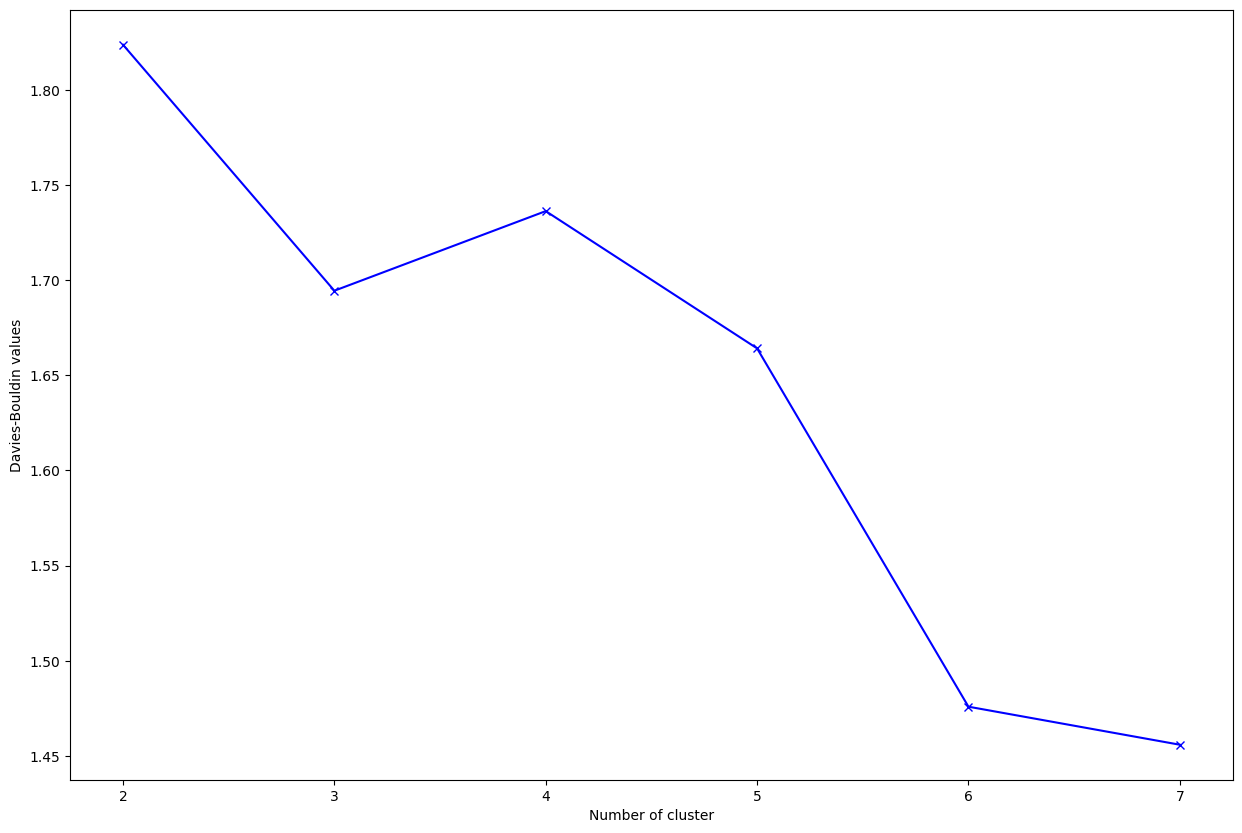

In [52]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

### Silhouette score

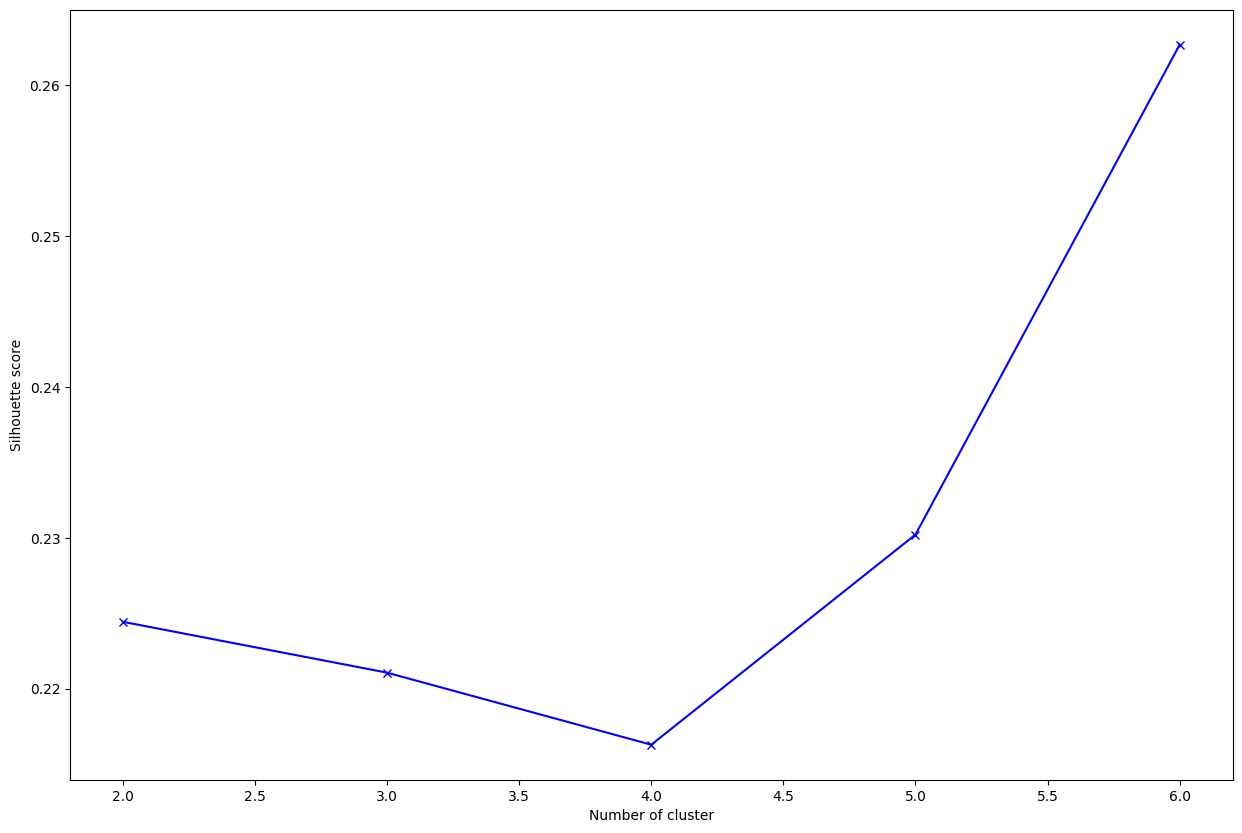

In [53]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [55]:
cluster = GaussianMixture(n_components=6, random_state=10)

cluster.fit(Xs)

aux["cl"] = Xs["cl"] = aux_dum['cl']=[str(x) for x in cluster.predict(Xs)]

In [56]:
aux.head()

,fsexual,edad,embarazos,entidad,ocupacion,usoAnticon,educacion,estadoCivS,z1_f,z2_f,z3_f,cl_f,z1,z2,z3,cl
0,45,24,7,OTROS,EMPLEADA,No,Sin acceso,Soltera,-1.665658,26.626230,6.902027,2,-1.665985,26.628073,-0.277688,5
1,15,30,5,CIUDAD DE MEXICO,NO PERCIBE INGRESO,No,Educación Media,Con pareja,4.123871,-3.399154,4.688545,1,4.123798,-3.398010,0.580789,4
2,45,38,5,CIUDAD DE MEXICO,EMPLEADA,No,Educación Básica,Con pareja,12.336715,26.542303,4.933822,1,12.334704,26.542085,0.693758,1
3,16,23,4,CIUDAD DE MEXICO,NO PERCIBE INGRESO,Si,Educación Media,Con pareja,-2.867406,-2.341561,3.688436,1,-2.867594,-2.340718,0.939428,4
4,17,18,4,CIUDAD DE MEXICO,NO PERCIBE INGRESO,Si,Educación Básica,Con pareja,-7.860178,-1.305987,3.689011,1,-7.861235,-1.308669,1.025374,1


### Cluster visualization

In [ ]:
fig = px.scatter_3d(aux, 
                 x='z1', y='z2',z= 'z3',  
                 color='cl',
                 #symbol='ocupacion',
                 #labels='',
                 #text='wav_filename',
                 hover_data=['fsexual', 'edad', 'embarazos', 'entidad', 'ocupacion', 'usoAnticon','educacion', 'estadoCivS'],
                 template="simple_white"
                 #template="plotly_dark",
                 )

fig.show()

## Cluster

In [58]:
aux_dum.groupby('cl')['fsexual'].count()/len(Xs)*100

cl
0    16.799804
1    24.413634
2    14.859364
3     0.265255
4    15.595956
5    28.065987
Name: fsexual, dtype: float64

In [59]:
aux_dum.groupby('cl').mean()

/tmp/ipykernel_29/3678801633.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,fsexual,edad,embarazos,entidad_CIUDAD DE MEXICO,entidad_ESTADO DE MEXICO,ocupacion_EMPLEADA,ocupacion_ESTUDIANTE,usoAnticon_Si,educacion_Educación Básica,educacion_Educación Media,educacion_Educación superior,estadoCivS_Con pareja
cl,,,,,,,,,,,,
0,18.121819,25.865063,0.327989,0.000000,1.0,0.354467,0.192020,0.331572,0.645351,0.000000,0.337159,0.407603
1,18.057417,25.771500,0.340451,0.959716,0.0,0.315921,0.124279,0.315336,1.000000,0.000000,0.000000,0.460468
2,18.126605,25.903055,0.284655,0.000000,1.0,0.330999,0.306076,0.325232,0.000000,1.000000,0.000000,0.354274
3,18.623077,25.865385,0.234615,1.000000,0.0,0.323077,0.180769,0.323077,0.000000,0.000000,0.000000,0.000000
4,18.642572,25.864264,0.415124,0.934977,0.0,0.338981,0.149670,0.307255,0.000000,0.725388,0.257932,1.000000
5,18.632606,25.856997,0.168048,0.904653,0.0,0.368484,0.394257,0.303526,0.000000,0.690731,0.308142,0.000000


Cluster 0 -> Estado de mexico, Sin trabajo, No usa condon, Educación basica  
Cluster 1 -> Ciudad de Mexico, Sin trabajo, No usa condon, Educación basica  
Cluster 2 -> Ciudad de Mexico, No estudia, No usa condon, Educación media, Grupo con mas pareja, Mayor numero embarazos  
Cluster 3 -> Area metropolitana, Empleada/estudiante, Menos uso de condon, Superior
Cluster 4 -> Estado de mexico, Distribución uniforme empleo, Educación media, 
Cluster 5 -> Ciudad de Mexico, Estudiante, Educación medica, Mas

# PCA Frequency

In [29]:
pca = PCA(n_components=3,svd_solver='full')
pca.fit(aux_freq)

PCA(n_components=3, svd_solver='full')

In [30]:
print(pca.explained_variance_ratio_)

[0.50830955 0.48617886 0.00436693]


In [31]:
z= pca.transform(aux_freq)

In [32]:
aux['z1_f'] = z[:,0]
aux['z2_f'] = z[:,1]
aux['z3_f'] = z[:,2]

## Data visualization

In [ ]:
fig = px.scatter(aux, 
                 x='z1_f', y='z2_f',  
                 color='educacion',
                 symbol='ocupacion',
                 #labels='',
                 #text='wav_filename',
                 hover_data=['fsexual', 'edad', 'embarazos', 'entidad', 'ocupacion', 'usoAnticon','educacion', 'estadoCivS'],
                 template="simple_white"
                 #template="plotly_dark",
                 )

fig.show()

## Number of clusters

In [36]:
sc = MinMaxScaler()
Xs_f = pd.DataFrame(data=sc.fit_transform(aux_freq), columns=aux_freq.columns, index=aux_freq.index)

In [37]:
sse,db,slc = {}, {}, {}
for k in range(2, 7):
    print(f'----------------{k}--------------------------')
    cluster = GaussianMixture(n_components=k, random_state=10).fit(Xs)
    clusters = cluster.predict(Xs_f)
    db[k] = davies_bouldin_score(Xs_f,clusters)
    slc[k] = silhouette_score(Xs_f,clusters)

----------------2--------------------------
----------------3--------------------------
----------------4--------------------------
----------------5--------------------------
----------------6--------------------------


### Davies-Bouldin values

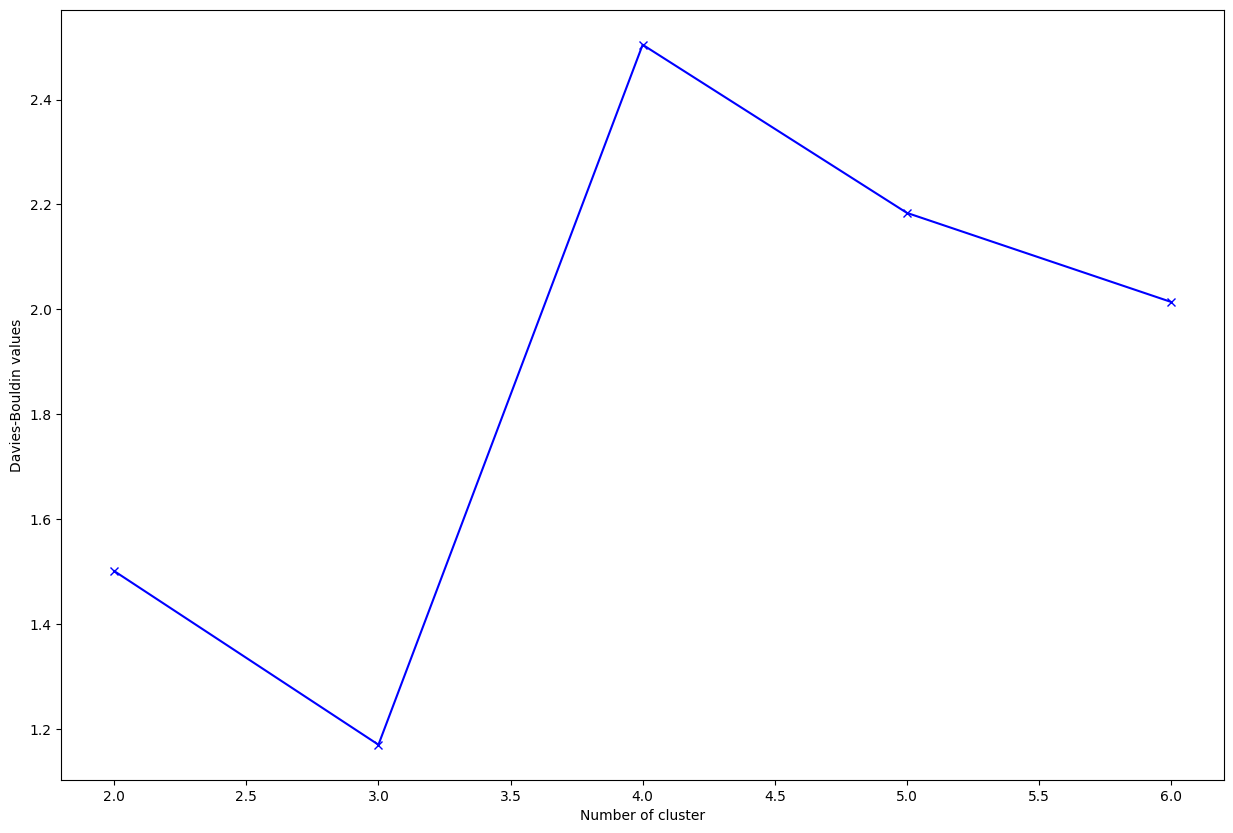

In [38]:
plt.figure(figsize=(15,10))
plt.plot(list(db.keys()), list(db.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

### Silhouette score

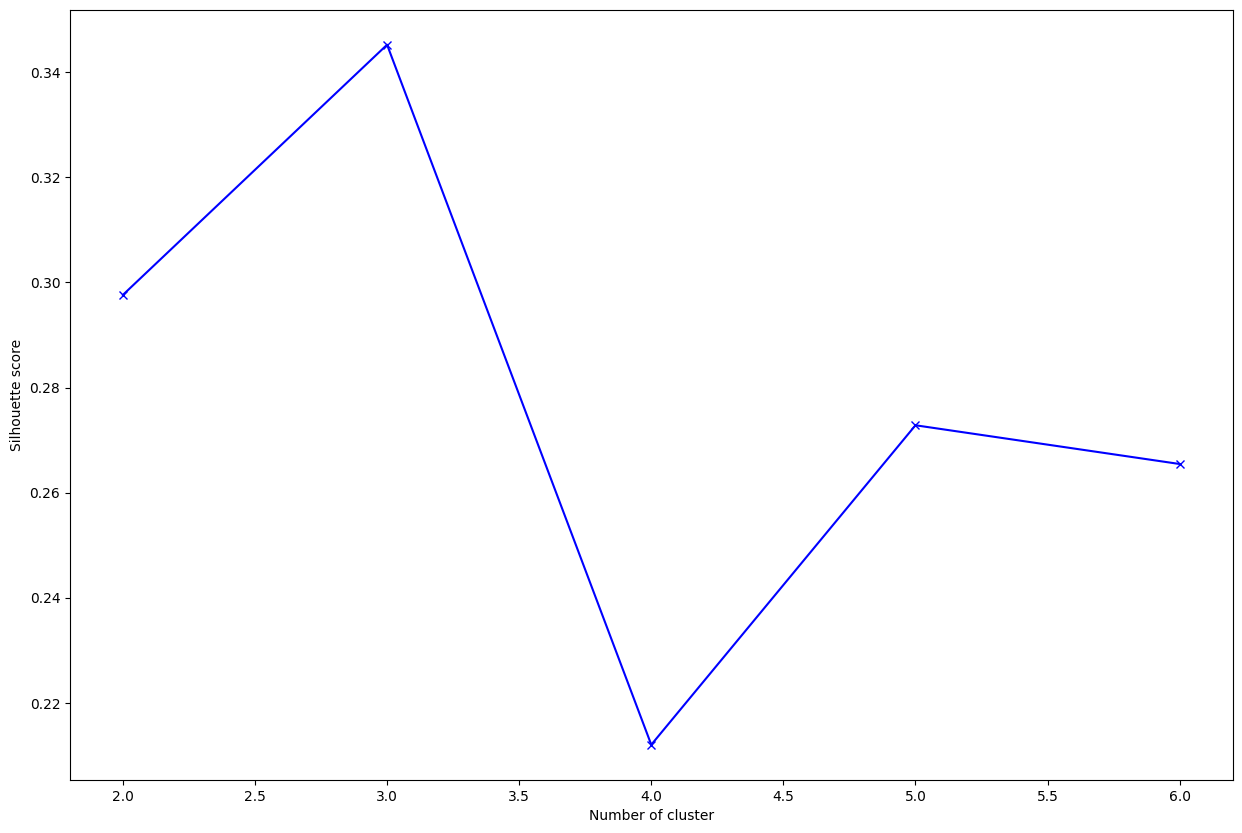

In [39]:
plt.figure(figsize=(15,10))
plt.plot(list(slc.keys()), list(slc.values()), "bx-")
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

In [41]:
cluster = GaussianMixture(n_components=3, random_state=10)

cluster.fit(Xs)

aux["cl_f"] = Xs_f["cl"] = aux_dum['cl_f']=[str(x) for x in cluster.predict(Xs)]

In [42]:
aux.head()

,fsexual,edad,embarazos,entidad,ocupacion,usoAnticon,educacion,estadoCivS,z1_f,z2_f,z3_f,cl_f
0,45,24,7,OTROS,EMPLEADA,No,Sin acceso,Soltera,-1.665658,26.626230,6.902027,2
1,15,30,5,CIUDAD DE MEXICO,NO PERCIBE INGRESO,No,Educación Media,Con pareja,4.123871,-3.399154,4.688545,1
2,45,38,5,CIUDAD DE MEXICO,EMPLEADA,No,Educación Básica,Con pareja,12.336715,26.542303,4.933822,1
3,16,23,4,CIUDAD DE MEXICO,NO PERCIBE INGRESO,Si,Educación Media,Con pareja,-2.867406,-2.341561,3.688436,1
4,17,18,4,CIUDAD DE MEXICO,NO PERCIBE INGRESO,Si,Educación Básica,Con pareja,-7.860178,-1.305987,3.689011,1


### Cluster visualization

In [ ]:
fig = px.scatter(aux, 
                 x='z1_f', y='z2_f',  
                 color='cl_f',
                 #symbol='ocupacion',
                 #labels='',
                 #text='wav_filename',
                 hover_data=['fsexual', 'edad', 'embarazos', 'entidad', 'ocupacion', 'usoAnticon','educacion', 'estadoCivS'],
                 template="simple_white"
                 #template="plotly_dark",
                 )

fig.show()

In [ ]:
fig = px.scatter_3d(aux, 
                 x='z1_f', y='z2_f',z= 'z3_f',  
                 color='cl_f',
                 #symbol='ocupacion',
                 #labels='',
                 #text='wav_filename',
                 hover_data=['fsexual', 'edad', 'embarazos', 'entidad', 'ocupacion', 'usoAnticon','educacion', 'estadoCivS'],
                 template="simple_white"
                 #template="plotly_dark",
                 )

fig.show()

## Cluster

In [47]:
aux_dum.groupby('cl_f')['fsexual'].count()/len(Xs)*100

cl_f
0    19.205460
1    38.949591
2    41.844948
Name: fsexual, dtype: float64

In [48]:
aux_dum.groupby('cl_f').mean()

,fsexual,edad,embarazos,entidad_CIUDAD DE MEXICO,entidad_ESTADO DE MEXICO,ocupacion_EMPLEADA,ocupacion_ESTUDIANTE,usoAnticon_Si,educacion_Educación Básica,educacion_Educación Media,educacion_Educación superior,estadoCivS_Con pareja
cl_f,,,,,,,,,,,,
0,18.363718,25.829748,0.214980,0.659017,0.336946,0.375564,0.335033,1.000000,0.318300,0.473625,0.200053,0.0
1,18.303080,25.812562,0.427288,0.652365,0.310964,0.291529,0.102310,0.315601,0.416418,0.425612,0.147991,1.0
2,18.346060,25.883338,0.203920,0.611810,0.312488,0.375975,0.330651,0.000000,0.308831,0.475205,0.208602,0.0


### Resumen

Cluster 0 -> Usan anti, sin pareja
Cluster 1 -> Mayor numero de embarazos, Con pareja, Sin actividad remunerada
Cluster 2 -> No usa anti, Sin pareja
